In [1]:
import os
os.environ["MKL_NUM_THREADS"]="8" 
os.environ["NUMEXPR_NUM_THREADS"]='8'
os.environ["OMP_NUM_THREADS"]='8'
import matplotlib.pyplot as plt
import types
import numpy as np
import tqdm.notebook
from mmd import MMD_3_Sample_Test
import torch
from torch import optim
import torch.nn as nn
import torch.utils
import torch.distributions as td

%matplotlib inline

from importlib import reload


import Generators, Features, Data, Likelihoods

from KernelWakeSleep import *

import Models

device = torch.device("cuda:0")
reload(Data)
reload(Models)

<module 'Models' from '/nfs/ghome/live/kevinli/Code/kws/Models.py'>

In [2]:
reload(Generators)
reload(Features)
reload(Likelihoods)

<module 'Likelihoods' from '/nfs/ghome/live/kevinli/Code/kws/Likelihoods.py'>

In [3]:
batch_size = 200
nsleep = 2000
nepoch = 10
nvalid = 200
torch.manual_seed(0)
np.random.seed(0)

# data

In [5]:
def sleep(gmm, *args):
    return gmm.sample_logp(*args)

def draw_sample(gmm, *args):
    return gmm.sample_logp(*args)[1]

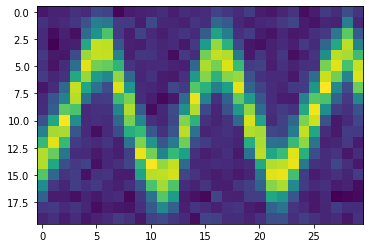

In [6]:
length = 30
Dx = 20
ang = np.pi/4.0
z0 = torch.tensor([0.8,0.0])
A = torch.tensor([[np.cos(ang), np.sin(ang)], [-np.sin(ang), np.cos(ang)]]) * 0.95
true_model = Models.LinearImage(Dx, A=A, z0=z0, rand_std=0.1, noise_std=0.05).to(device)
# true_model = LGSSM(2, A=A, z0=z0, rand_std=0.01, noise_std=0.1).to(device)
true_x = true_model.sample(3, length)
true_x_im = true_x.reshape(true_x.shape[0], length, true_model.Dx)
if true_model.Dx > 1:
    plt.imshow(true_x_im[0].cpu().numpy().T)
else:
    plt.plot(true_x_im[0].cpu().numpy())
lds  = Models.DeepImage(2, Dx, z0=torch.tensor([0.0,0.0]), rand_std=0.3, noise_std=1.0).to(device)

In [7]:
s = draw_sample(lds, 1000, length)
kernel_networks = [nn.Identity()]
kernel_networks = [Features.lin_feat(Dx*length, 200, bn=False).to(device) for i in range(1)]

sigma = estimate_median_distance(kernel_networks[0](s))
kernel = Kernel(kernel_networks, sigma , lam=1e-3, train_sigma=False, train_lam=True)

kernel.to(device)


Kernel(
  (kernel_networks): ModuleList(
    (0): Sequential(
      (0): Flatten()
      (1): Linear(in_features=600, out_features=200, bias=True)
      (2): Identity()
    )
  )
)

In [8]:

optimizer = optim.Adam(list(lds.parameters()), lr=0.001)
kernel_optimizer = optim.Adam(kernel.parameters(), lr=0.01)


Elogps = []
losses = []

log_lams = []
log_sigmas = []

network_norms = []
kernel_network_norms = []
kernel_network_feat_norms = []
noise_stds = []
rand_stds = []

network_grad_norms = []

In [53]:
import gc
gc.collect()

lds.train()
kernel.train()
nsleep = 2000
with tqdm.notebook.tqdm(range(5000-3905)) as t:
    for ei in t:


        X_tr = true_x

        data_0, data_1, norm, nat = sleep(lds, nsleep, length)
        data_0_val, data_1_val, norm_val, nat_val = sleep(lds, nsleep, length)
        S_val = lds.suff(data_1_val)
        
        if ei % 1 == 0:

            kernel_optimizer.zero_grad()

            Elogp_val = KRR_2(lds.suff, kernel, data_1_val, data_1, norm.detach(), nat.detach()).mean()

            loss_val = torch.mean((Elogp_val + norm_val - (nat_val * S_val).sum(-1))**2)

            loss_val.backward(retain_graph=False)

            kernel_optimizer.step()
            
            network_grad_norm = sum(map(lambda x: (x.grad**2).sum() if x.grad is not None else 0, kernel.parameters()))

            losses += loss_val.detach().cpu().numpy(),

            log_lams += kernel.log_lam.cpu().detach().numpy(),
            log_sigmas += kernel.log_sigma.cpu().detach().numpy(),

        Elogp = KRR_2(lds.suff, kernel, X_tr, data_1, norm, nat).mean()
        network_norm = sum(map(lambda x: (x**2).sum(), lds.parameters()))

        gen_loss = -Elogp 

        Elogps += Elogp.mean().detach().cpu().numpy(),

        optimizer.zero_grad()
        gen_loss.backward(retain_graph=False)

        network_norms += network_norm,
        network_grad_norm = sum(map(lambda x: (x.grad**2).sum() if x.grad is not None else 0, lds.parameters()))
        network_grad_norms += network_grad_norm,
        torch.nn.utils.clip_grad_norm_(lds.parameters(), 1e3)

        optimizer.step()
        t.set_postfix(Elogp=Elogp.item())

        noise_stds += lds.log_noise_std.exp().detach().cpu().numpy(),
        rand_stds += lds.log_rand_std.exp().detach().cpu().numpy(),

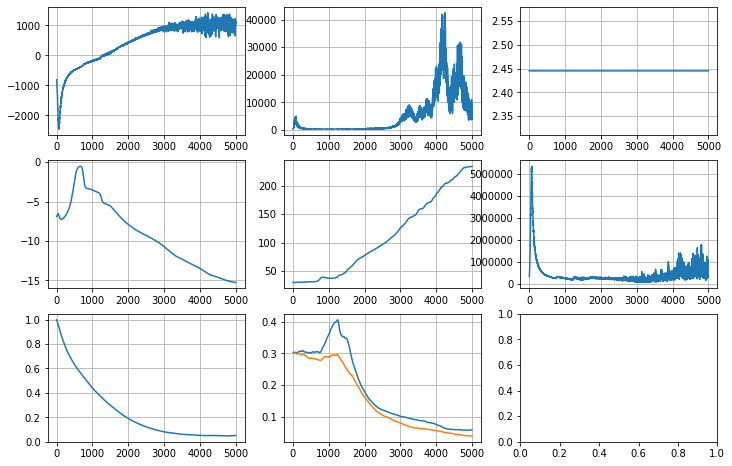

In [55]:
params = [Elogps,losses, log_sigmas, 
          log_lams, network_norms, network_grad_norms, 
          noise_stds, rand_stds]


nplot = len(params)
fig, axes = plt.subplots(3,3, figsize=(12,8), sharex=False)
axes = np.ravel(axes)


for i in range(nplot):
    axes[i].plot(params[i])
    
    axes[i].grid(True)
# axes[0].set_xlim([20000,2000])

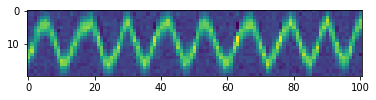

In [56]:
z, x = lds.sample_logp(10,101)[:2]
x_im = x.reshape(x.shape[0], -1, true_model.Dx)
if true_model.Dx > 1:
    plt.imshow(x_im[0].cpu().numpy().T, vmin=-0.3, vmax=1.3)
else:
    plt.plot(x_im[0].cpu().numpy())
    plt.plot(true_x[0].cpu().numpy())

In [57]:
import KernelWakeSleep as kws
true_x_im, z, x_im = kws.to_np(true_x.reshape(-1,length,Dx), z, x_im)

torch.save([lds.state_dict(), kernel.state_dict(), optimizer.state_dict(), kernel_optimizer.state_dict(), params], "models/kws/osc_s00")

[]

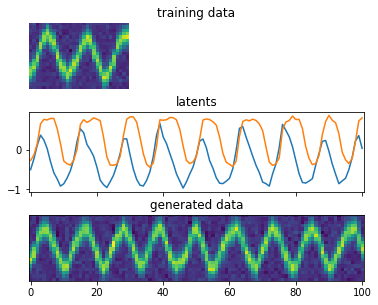

In [58]:
fig, axes = plt.subplots(3,1, figsize=(6,5), sharex=True)


ax = axes[0]
ax.set_title("training data")
ax.imshow(true_x_im[2].T, vmin=-0.2, vmax=1.2)
ax.set_axis_off()

ax = axes[1]
ax.set_title("latents")
ax.plot(z[0])

ax = axes[2]
ax.set_title("generated data")
ax.imshow(x_im[2].T, vmin=-0.2, vmax=1.2)
ax.set_yticks([])

# np.savez("results/oscillation", true_x_im=true_x_im, x_im = x_im, z=z)